<a href="https://colab.research.google.com/github/machtg/movie-recommendation-bangkit/blob/movielens/Movie_Recommendation_with_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation

by Hanjaya Suryalim and Maclaurin Hutagalung

Data was taken from [MovieLens dataset](https://grouplens.org/datasets/movielens/100k/). The data consists of movies ratings (on a scale of 1 to 5).

Almost all of the code being used here are taken from [Recommendation Systems course by Google](https://colab.research.google.com/github/google/eng-edu/blob/master/ml/recommendation-systems/recommendation-systems.ipynb).

We put our best effort to understand the codes and try to understand the algorithm and the results by changing hyper-parameters.


In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

We import the required packages.

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
# @title Imports
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Download the MovieLens Data, and create DataFrames containing movies, users, and ratings.

In [31]:
# @title Load the MovieLens data.

# Download MovieLens data.
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


# I. Exploring the Movielens Data

### Users
Some basic statistics describing the numeric user features.

In [32]:
users.describe()

,age
count,943.000
mean,34.052
std,12.193
min,7.000
25%,25.000
50%,31.000
75%,43.000
max,73.000


Print some basic statistics describing the categorical user features

In [33]:
users.describe(include=[np.object])

,user_id,sex,occupation,zip_code
count,943,943,943,943
unique,943,2,21,795
top,760,M,student,55414
freq,1,670,196,9


### Movies

Let's look at information about the movies and their ratings.

In [0]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [35]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

,title,rating count,rating mean
49,Star Wars (1977),583,4.358
257,Contact (1997),509,3.804
99,Fargo (1996),508,4.156
180,Return of the Jedi (1983),507,4.008
293,Liar Liar (1997),485,3.157
285,"English Patient, The (1996)",481,3.657
287,Scream (1996),478,3.441
0,Toy Story (1995),452,3.878
299,Air Force One (1997),431,3.631
120,Independence Day (ID4) (1996),429,3.438


In [36]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

,title,rating count,rating mean
407,"Close Shave, A (1995)",112,4.491
317,Schindler's List (1993),298,4.466
168,"Wrong Trousers, The (1993)",118,4.466
482,Casablanca (1942),243,4.457
113,Wallace & Gromit: The Best of Aardman Animatio...,67,4.448
63,"Shawshank Redemption, The (1994)",283,4.445
602,Rear Window (1954),209,4.388
11,"Usual Suspects, The (1995)",267,4.386
49,Star Wars (1977),583,4.358
177,12 Angry Men (1957),125,4.344


# II. Preliminaries

Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$th movies by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each rwo $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.



## Sparse Representation of the Rating Matrix

The rating matrix could be very large and, in general, most of the entries are unobserved, since a given user will only rate a small subset of movies. For effcient representation, we will use a [tf.SparseTensor](https://www.tensorflow.org/api_docs/python/tf/SparseTensor). A `SparseTensor` uses three tensors to represent the matrix: `tf.SparseTensor(indices, values, dense_shape)` represents a tensor, where a value $A_{ij} = a$ is encoded by setting `indices[k] = [i, j]` and `values[k] = a`. The last tensor `dense_shape` is used to specify the shape of the full underlying matrix.

#### Toy example
Assume we have $2$ users and $4$ movies. Our toy ratings dataframe has three ratings,

user\_id | movie\_id | rating
--:|--:|--:
0 | 0 | 5.0
0 | 1 | 3.0
1 | 3 | 1.0

The corresponding rating matrix is

$$
A =
\begin{bmatrix}
5.0 & 3.0 & 0 & 0 \\
0   &   0 & 0 & 1.0
\end{bmatrix}
$$

And the SparseTensor representation is,
```python
SparseTensor(
  indices=[[0, 0], [0, 1], [1,3]],
  values=[5.0, 3.0, 1.0],
  dense_shape=[2, 4])
```



### Step 1: Build a tf.SparseTensor representation of the Rating Matrix.

We write a function that maps from our `ratings` DataFrame to a `tf.SparseTensor`.


In [0]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

## Calculating the error

The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only (we will revisit this later). It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.



### Step 2: Mean Squared Error

Write a TensorFlow function that takes a sparse rating matrix $A$ and the two embedding matrices $U, V$ and returns the mean squared error $\text{MSE}(A, UV^\top)$.

Note: One approach is to compute the full prediction matrix $UV^\top$, then gather the entries corresponding to the observed pairs. The memory cost of this approach is $O(NM)$. For the MovieLens dataset, this is fine, as the dense $N \times M$ matrix is small enough to fit in memory ($N = 943$, $M = 1682$).

Another approach (given in the alternate solution below) is to only gather the embeddings of the observed pairs, then compute their dot products. The memory cost is $O(|\Omega| d)$ where $d$ is the embedding dimension. In our case, $|\Omega| = 10^5$, and the embedding dimension is on the order of $10$, so the memory cost of both methods is comparable. But when the number of users or movies is much larger, the first approach becomes infeasible.

In [0]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

# III. Training a Matrix Factorization model

## CFModel (Collaborative Filtering Model) helper class
This is a simple class to train a matrix factorization model using stochastic gradient descent.

The class constructor takes
- the user embeddings U (a `tf.Variable`).
- the movie embeddings V, (a `tf.Variable`).
- a loss to optimize (a `tf.Tensor`).
- an optional list of metrics dictionaries, each mapping a string (the name of the metric) to a tensor. These are evaluated and plotted during training (e.g. training error and test error).

After training, one can access the trained embeddings using the `model.embeddings` dictionary.


In [0]:
# @title CFModel helper class.
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

### Step 3: Build a Matrix Factorization model and train it

Using `sparse_mean_square_error` function, we write a function that builds a `CFModel` by creating the embedding variables and the train and test losses.

In [0]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

Now it's time to train the model!

We try different parameters (embedding dimension, learning rate, iterations) to find the best results.

 iteration 500: train_error=0.664420, test_error=1.118857

[{'test_error': 1.1188573, 'train_error': 0.6644203}]

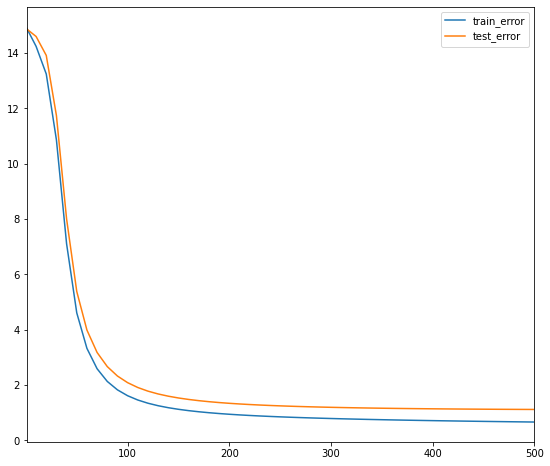

In [41]:
# Build the CF model and train it.
model = build_model(ratings, embedding_dim=20, init_stddev=0.5)
model.train(num_iterations=500, learning_rate=7.)

# IV. Inspecting the Embeddings

In this section, we take a closer look at the learned embeddings, by
- computing your recommendations
- looking at the nearest neighbors of some movies,
- looking at the norms of the movie embeddings,
- visualizing the embedding in a projected embedding space.

### Step 4: Write a function that computes the scores of the candidates
We start by writing a function that, given a query embedding $u \in \mathbb R^d$ and item embeddings $V \in \mathbb R^{N \times d}$, computes the item scores.

As discussed in the lecture, there are different similarity measures we can use, and these can yield different results. We will compare the following:
- dot product: the score of item j is $\langle u, V_j \rangle$.
- cosine: the score of item j is $\frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$.

Hints:
- you can use [`np.dot`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) to compute the product of two np.Arrays.
- you can use [`np.linalg.norm`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.norm.html) to compute the norm of a np.Array.

In [0]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

Equipped with this function, we can compute recommendations, where the query embedding can be either a user embedding or a movie embedding.

In [0]:
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][943], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # remove movies that are already rated
      rated_movies = ratings[ratings.user_id == "943"]["movie_id"].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  

def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

### Movie Nearest neighbors

Let's look at the neareast neighbors for some of the movies.

In [44]:
movie_neighbors(model, "Godfather", DOT)
movie_neighbors(model, "Godfather", COSINE)

Nearest neighbors of : Godfather, The (1972).
[Found more than one matching movie. Other candidates: Godfather: Part II, The (1974)]


,dot score,titles,genres
271,5.744,Good Will Hunting (1997),Drama
407,5.738,"Close Shave, A (1995)",Animation-Comedy-Thriller
312,5.616,Titanic (1997),Action-Drama-Romance
126,5.561,"Godfather, The (1972)",Action-Crime-Drama
315,5.550,As Good As It Gets (1997),Comedy-Drama
301,5.476,L.A. Confidential (1997),Crime-Film-Noir-Mystery-Thriller


Nearest neighbors of : Godfather, The (1972).
[Found more than one matching movie. Other candidates: Godfather: Part II, The (1974)]


,cosine score,titles,genres
126,1.000,"Godfather, The (1972)",Action-Crime-Drama
99,0.954,Fargo (1996),Crime-Drama-Thriller
650,0.950,Glory (1989),Action-Drama-War
11,0.940,"Usual Suspects, The (1995)",Crime-Thriller
317,0.923,Schindler's List (1993),Drama-War
49,0.920,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War


It seems that the quality of learned embeddings may not be very good. This will be addressed in Section V by adding several regularization techniques.

## Movie Embedding Norm

We can also observe that the recommendations with dot-product and cosine are different: with dot-product, the model tends to recommend popular movies. This can be explained by the fact that in matrix factorization models, the norm of the embedding is often correlated with popularity (popular movies have a larger norm), which makes it more likely to recommend more popular items. We can confirm this hypothesis by sorting the movies by their embedding norm, as done in the next cell.

In [0]:
# @title Embedding Visualization code.

def movie_embedding_norm(models):
  """Visualizes the norm and number of ratings of the movie embeddings.
  Args:
    model: A MFModel object.
  """
  if not isinstance(models, list):
    models = [models]
  df = pd.DataFrame({
      'title': movies['title'],
      'genre': movies['genre'],
      'num_ratings': movies_ratings['rating count'],
  })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["movie_id"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

In [46]:
movie_embedding_norm(model)

alt.HConcatChart(...)

Note: Depending on how the model is initialized, you may observe that some niche movies (ones with few ratings) have a high norm, leading to spurious recommendations. This can happen if the embedding of that movie happens to be initialized with a high norm. Then, because the movie has few ratings, it is infrequently updated, and can keep its high norm. This will be alleviated by using regularization.

Try changing the value of the hyper-parameter `init_stddev`. One quantity that can be helpful is that the expected norm of a $d$-dimensional vector with entries $\sim \mathcal N(0, \sigma^2)$ is approximatley $\sigma \sqrt d$.

How does this affect the embedding norm distribution, and the ranking of the top-norm movies?

 iteration 500: train_error=0.755483, test_error=0.893475Nearest neighbors of : Godfather, The (1972).
[Found more than one matching movie. Other candidates: Godfather: Part II, The (1974)]


,dot score,titles,genres
99,5.998,Fargo (1996),Crime-Drama-Thriller
126,5.852,"Godfather, The (1972)",Action-Crime-Drama
482,5.336,Casablanca (1942),Drama-Romance-War
49,5.331,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
514,5.318,"Boot, Das (1981)",Action-Drama-War
356,5.254,One Flew Over the Cuckoo's Nest (1975),Drama


Nearest neighbors of : Godfather, The (1972).
[Found more than one matching movie. Other candidates: Godfather: Part II, The (1974)]


,cosine score,titles,genres
126,1.000,"Godfather, The (1972)",Action-Crime-Drama
186,0.954,"Godfather: Part II, The (1974)",Action-Crime-Drama
1016,0.952,Trees Lounge (1996),Drama
12,0.952,Mighty Aphrodite (1995),Comedy
99,0.952,Fargo (1996),Crime-Drama-Thriller
1141,0.951,When We Were Kings (1996),Documentary


alt.HConcatChart(...)

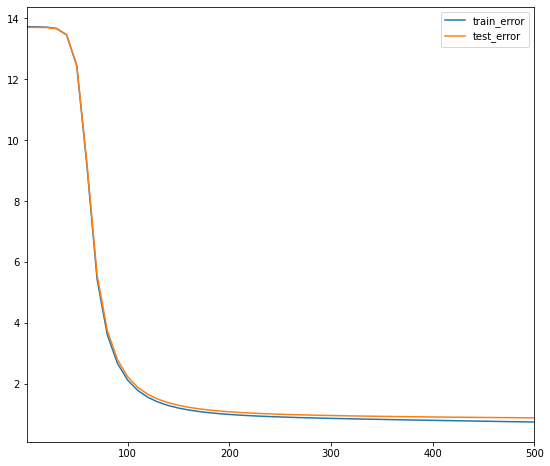

In [47]:
model_lowinit = build_model(ratings, embedding_dim=20, init_stddev=0.05)
model_lowinit.train(num_iterations=500, learning_rate=7.)
movie_neighbors(model_lowinit, "Godfather", DOT)
movie_neighbors(model_lowinit, "Godfather", COSINE)
movie_embedding_norm([model, model_lowinit])

# V. Regularization In Matrix Factorization

In the previous section, our loss was defined as the mean squared error on the observed part of the rating matrix.  As discussed in the lecture, this can be problematic as the model does not learn how to place the embeddings of irrelevant movies. This phenomenon is known as *folding*.

We will add regularization terms that will address this issue. We will use two types of regularization:
- Regularization of the model parameters. This is a common $\ell_2$ regularization term on the embedding matrices, given by $r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.
- A global prior that pushes the prediction of any pair towards zero, called the *gravity* term. This is given by $g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2$.

The total loss is then given by
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$
where $\lambda_r$ and $\lambda_g$ are two regularization coefficients (hyper-parameters).

### Step 5: Build a regularized Matrix Factorization model and train it
Write a function that builds a regularized model. You are given a function `gravity(U, V)` that computes the gravity term given the two embedding matrices $U$ and $V$.


In [0]:
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of movie ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"user_id": U, "movie_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

It is now time to train the regularized model! You can try different values of the regularization coefficients, and different embedding dimensions.

 iteration 500: train_error_observed=1.820600, test_error_observed=2.089090, observed_loss=1.820600, regularization_loss=0.432810, gravity_loss=1.594708

[{'test_error_observed': 2.0890903, 'train_error_observed': 1.8205997},
 {'gravity_loss': 1.5947084,
  'observed_loss': 1.8205997,
  'regularization_loss': 0.43281016}]

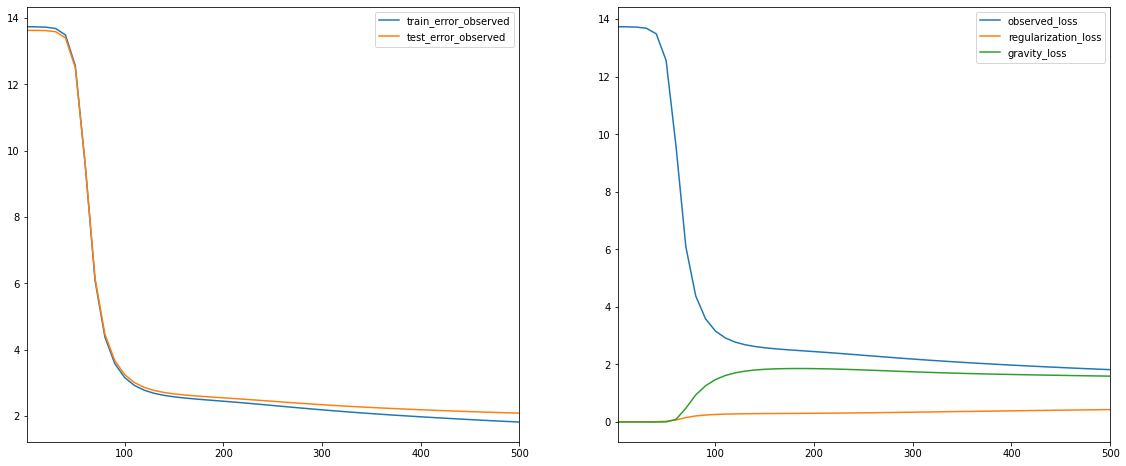

In [50]:
reg_model = build_regularized_model(
    ratings, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=20,
    init_stddev=.05)
reg_model.train(num_iterations=500, learning_rate=7.)

Observe that adding the regularization terms results in a higher MSE, both on the training and test set. However, as we will see, the quality of the recommendations improves. This highlights a tension between fitting the observed data and minimizing the regularization terms. Fitting the observed data often emphasizes learning high similarity (between items with many interactions), but a good embedding representation also requires learning low similarity (between items with few or no interactions).

### Inspect the results
Let's see if the results with regularization look better.

In [0]:
user_recommendations(reg_model, DOT, exclude_rated=True, k=10)

Hopefully, these recommendations look better. You can change the similarity measure from COSINE to DOT and observe how this affects the recommendations.

Since the model is likely to recommend items that you rated highly, you have the option to exclude the items you rated, using `exclude_rated=True`.

In the following cells, we display the nearest neighbors, the embedding norms, and the t-SNE projection of the movie embeddings.

In [52]:
movie_neighbors(reg_model, "Godfather", DOT)
movie_neighbors(reg_model, "Godfather", COSINE)

Nearest neighbors of : Godfather, The (1972).
[Found more than one matching movie. Other candidates: Godfather: Part II, The (1974)]


,dot score,titles,genres
49,12.232,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
126,11.424,"Godfather, The (1972)",Action-Crime-Drama
99,11.386,Fargo (1996),Crime-Drama-Thriller
180,10.584,Return of the Jedi (1983),Action-Adventure-Romance-Sci-Fi-War
257,10.358,Contact (1997),Drama-Sci-Fi
312,10.109,Titanic (1997),Action-Drama-Romance


Nearest neighbors of : Godfather, The (1972).
[Found more than one matching movie. Other candidates: Godfather: Part II, The (1974)]


,cosine score,titles,genres
126,1.000,"Godfather, The (1972)",Action-Crime-Drama
514,0.974,"Boot, Das (1981)",Action-Drama-War
99,0.950,Fargo (1996),Crime-Drama-Thriller
6,0.945,Twelve Monkeys (1995),Drama-Sci-Fi
49,0.929,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
274,0.921,Sense and Sensibility (1995),Drama-Romance


Here we compare the embedding norms for `model` and `reg_model`. Selecting a subset of the embeddings will highlight them on both charts simultaneously.

In [53]:
movie_embedding_norm([model, reg_model])

alt.HConcatChart(...)

### Conclusion
This concludes this section on matrix factorization models. Note that while the scale of the problem is small enough to allow efficient training using SGD, many practical problems need to be trained using more specialized algorithms such as Alternating Least Squares (see [tf.contrib.factorization.WALSMatrixFactorization](https://www.tensorflow.org/api_docs/python/tf/contrib/factorization/WALSMatrixFactorization) for a TF implementation).